# BCM Rule - recurrent network

## Single postsynaptic neuron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
%matplotlib inline

Updating functions for a single neuron $y$, its weights $w$ and the threshold $\theta$:
$$ \mathbf{y}(t) = \mathbf{w}\mathbf{y} $$
$$ \frac{d\mathbf{w}}{dt} = \eta \mathbf{x} \mathbf{y}(\mathbf{y}(t)-\mathbf{\theta}) $$
$$ \frac{d\mathbf{\theta}}{dt} = \frac{\mathbf{y}^2}{y_0} $$

In [7]:
class NeuralNet(object):
    
    def __init__(self, FF_NUM=3, REC_NUM=10, TOT_TIME=20, STEPS_DIM=0.0001, STARTING_RATE = 20,
                   TARGET_RATE=10, THETA_START=0.07, ETA=float('1e-3'), TAU=0.03, TIME_CONST = 0.01,
                   FF_PL=False, REC_PL=True):
        self.FF_NUM = FF_NUM
        self.REC_NUM = REC_NUM
        self.TOT_TIME = TOT_TIME
        self.STEPS_DIM = STEPS_DIM
        self.STARTING_RATE = STARTING_RATE #starting rate for recurrent network
        self.TARGET_RATE = TARGET_RATE
        self.THETA_START = THETA_START
        self.ETA = ETA
        self.TAU = TAU #for weights
        self.FF_PL = FF_PL
        self.REC_PL = REC_PL
        self.TIME_CONST = TIME_CONST #for rate
        
        self.change_values()
        
        
    def __repr__(self):
        return '''%d FF neurons\n%d REC neurons''' % (self.FF_NUM, self.REC_NUM) 
        
        
    def change_values(self):
        
        self.STEPS_N = round(self.TOT_TIME/self.STEPS_DIM) # time steps = total simulation time / simulation step size
        self.time_vect = np.linspace(0,self.TOT_TIME, self.STEPS_N) # create a time vector of size TOT.time and step size 
        
        self.rec_nn = np.zeros((self.REC_NUM, self.STEPS_N)) # create empty array with size of the recurrent network
        self.rec_nn[:,0] = np.random.randint(0,self.STARTING_RATE,self.REC_NUM) # intial firing rates at time step 0
        
        # create a random weight matrix for feed-forward input (size REC x FF) 
        self.w_ff = np.random.uniform(0.5, 2, [self.REC_NUM, self.FF_NUM]) #random uniform rates [0.5, 2] Hz (Clopath)
        
        # create a random weight matrix for the recurrent network
        self.w_rec = np.zeros((self.REC_NUM, self.REC_NUM, self.STEPS_N))
        self.w_rec[:,:,0] = 0.25 #recurrent weights of 0.25 Hz (Clopath)
        
        periodic_sig = np.zeros((self.FF_NUM, (round(10/self.STEPS_DIM))))
        periodic_sig[:,0:round(periodic_sig.shape[1]/2)] = 0
        
        self.ff_nn = np.tile(periodic_sig, [1, 50])
        
        self.theta = np.zeros((self.REC_NUM, self.STEPS_N))
        self.theta[:,0] = self.THETA_START
    
    
    def run_network(self):
        for i in range(1,self.STEPS_N):
            np.fill_diagonal(self.w_rec[:,:,i-1], 0) # set diagonal to 0 to prevent self-excitation
            
            self.rec_nn[:,i] = self.rec_nn[:,i-1] + (self.STEPS_DIM)*(
                    -self.rec_nn[:,i-1] + self.w_rec[:,:,i-1].dot(self.rec_nn[:,i-1]) + 
                    self.w_ff[:,:].dot(self.ff_nn[:,i-1]))
            
            self.theta[:,i] = self.theta[:,i-1] + (self.STEPS_DIM/self.TAU) * (
                -self.theta[:,i-1] + (self.rec_nn[:,i]**2)/self.TARGET_RATE)
                        
            if self.REC_PL:
                self.w_rec[:,:,i-1] = self.w_rec[:,:,i-1].clip(0)
                
                self.w_rec[:,:,i] = self.w_rec[:,:,i-1] + self.STEPS_DIM*self.ETA *(
                    self.w_rec[:,:,i-1] * (self.rec_nn[:,i-1]*(self.rec_nn[:,i-1] - self.theta[:,i-1])).T).T
                

            elif self.FF_PL:
                self.w_ff[:,:,i-1] = self.w_ff[:,:,i-1].clip(0)
                self.w_ff[:,:] = self.w_ff[:,:] + self.STEPS_DIM*self.ETA *(
                    self.w_ff[:,:] * (self.ff_nn[:,i-1]*(self.ff_nn[:,i-1] - self.theta[:,i-1])).T).T
                
    def plot_nn(self):
        f, ax = plt.subplots(1,2, figsize = (20,5))
        
        ax[0].plot(self.time_vect, [plastic_recurr.TARGET_RATE]*plastic_recurr.time_vect.shape[0], 'k--')
                   
        for i in range(self.REC_NUM):
            ax[0].plot(self.time_vect, self.rec_nn[i,0:self.time_vect.shape[0]])
        
        for i in range(self.FF_NUM):
            ax[0].plot(self.time_vect, self.ff_nn[i,0:self.time_vect.shape[0]], 'k')
            
        rec_weight_map = ax[1].pcolor(self.w_rec[:,:,self.STEPS_N-1], cmap=plt.cm.Blues)
        
            

In [8]:
#%%timeit
plastic_recurr = NeuralNet()


In [9]:
#%%timeit
plastic_recurr.run_network()


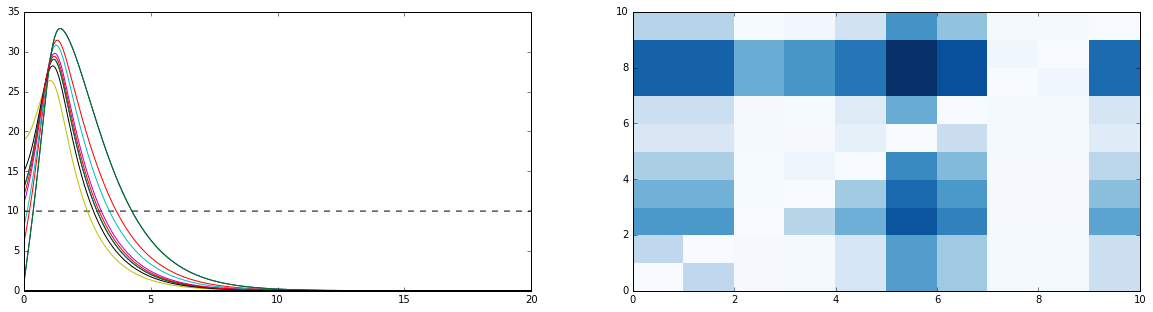

In [10]:
plastic_recurr.plot_nn()


In [6]:
print(plastic_recurr.w_rec[:,:,plastic_recurr.STEPS_N-1])

[[  0.00000000e+00   1.01453266e-01  -4.91998997e-06   5.76656837e-02
   -3.48808550e-06  -3.48808550e-06   6.63566453e-02  -5.36357764e-06
    5.76656837e-02   3.18775618e-02]
 [  2.52103175e-02   0.00000000e+00  -2.19974754e-06   3.15688291e-02
   -1.85501261e-06  -1.85501261e-06   3.82210273e-02  -2.30575702e-06
    3.15688291e-02   1.33801974e-02]
 [  1.33810822e-01   1.69562411e-01   0.00000000e+00   1.40247747e-01
    8.73521380e-02   8.73521380e-02   1.46447058e-01  -8.85008969e-06
    1.40247747e-01   1.20061624e-01]
 [  4.36708894e-02   9.51673360e-02  -4.40187838e-06   0.00000000e+00
   -3.25541734e-06  -3.25541734e-06   6.04819956e-02  -4.75844352e-06
    5.20280604e-02   2.72894901e-02]
 [  9.48667762e-02   1.42989323e-01  -7.68327671e-06   1.03720482e-01
    0.00000000e+00   3.29169831e-02   1.12132851e-01  -9.25018227e-06
    1.03720482e-01   7.57003639e-02]
 [  9.48667762e-02   1.42989323e-01  -7.68327671e-06   1.03720482e-01
    3.29169831e-02   0.00000000e+00   1.12132

In [ ]:
test = np.random.random((2,2,2))
print(test)

In [ ]:
print(test[:,:,1])

print(np.fill_diagonal(test[:,:,1], 0))